In [45]:
import csv
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from scipy.sparse import load_npz
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


X_train_tfidf = load_npz('trained_weights/tfidf/X_train_tfidf_300.npz')
X_test_tfidf = load_npz('trained_weights/tfidf/X_test_tfidf_300.npz')
#X_train = X_train_tfidf.toarray()
X_train = np.load('trained_weights/tfidf/X_train_tfidf_pca.npy')
#X_test = X_test_tfidf.toarray()
X_test = np.load('trained_weights/tfidf/X_test_tfidf_pca.npy')


y_train = np.load('trained_weights/tfidf/y_train_300.npy')
y_test = np.load('trained_weights/tfidf/y_test_300.npy')

x_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

x_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)


train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(x_test, y_test)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


/home/andrew/dev/cs491ml/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


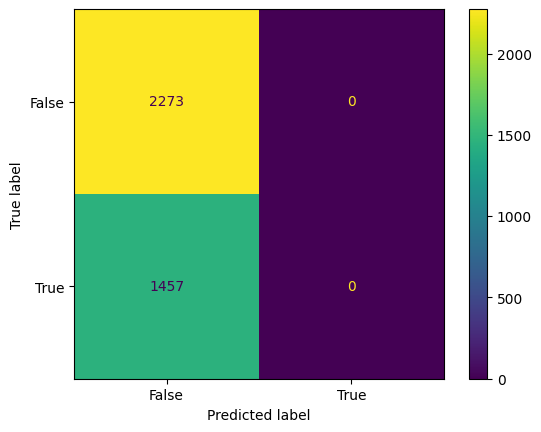

Epoch 1/10, Loss: 0.0506, Val Loss: 0.1054, Val Acc: 0.9576, Precision: 0.9482, Recall: 0.9430, F1 Score: 0.9456
Epoch 2/10, Loss: 0.0945, Val Loss: 0.0914, Val Acc: 0.9662, Precision: 0.9555, Recall: 0.9581, F1 Score: 0.9568
Epoch 3/10, Loss: 0.0020, Val Loss: 0.1029, Val Acc: 0.9606, Precision: 0.9210, Recall: 0.9835, F1 Score: 0.9512
Epoch 4/10, Loss: 0.0003, Val Loss: 0.0957, Val Acc: 0.9660, Precision: 0.9422, Recall: 0.9725, F1 Score: 0.9571
Epoch 5/10, Loss: 0.0038, Val Loss: 0.1091, Val Acc: 0.9558, Precision: 0.9729, Recall: 0.9121, F1 Score: 0.9416
Epoch 6/10, Loss: 0.0017, Val Loss: 0.1035, Val Acc: 0.9592, Precision: 0.9725, Recall: 0.9218, F1 Score: 0.9464
Epoch 7/10, Loss: 0.0308, Val Loss: 0.0985, Val Acc: 0.9678, Precision: 0.9496, Recall: 0.9691, F1 Score: 0.9592
Epoch 8/10, Loss: 0.0002, Val Loss: 0.1140, Val Acc: 0.9563, Precision: 0.9771, Recall: 0.9094, F1 Score: 0.9421
Epoch 9/10, Loss: 0.0005, Val Loss: 0.1111, Val Acc: 0.9668, Precision: 0.9382, Recall: 0.9794, 

In [16]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.a = nn.Linear(300,300)
        self.b = nn.Linear(300,256)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.a(x))
        x = self.relu(self.b(x))
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x
    
# Instantiate the model, define loss function, and optimizer
model = SimpleNN()
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.0005)
model.eval()
with torch.no_grad():
    val_loss = 0.0
    correct = 0
    total = 0
    predictions = []

    for inputs, labels in val_loader:
        outputs = model(inputs)
        val_loss += criterion(outputs, labels.unsqueeze(1).float()).item()
        predicted = (outputs > 0.5).float()
        predictions.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(1)).sum().item()

    val_loss /= len(val_loader)
    accuracy = correct / total

    # Calculate precision, recall, and F1 score
    y_true = y_test
    y_pred = predictions
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True]) 
    cm_display.plot()
    plt.show() 
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()

     # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0
        predictions = []

        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs, labels.unsqueeze(1).float()).item()
            predicted = (outputs > 0.5).float()
            predictions.extend(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()

        val_loss /= len(val_loader)
        accuracy = correct / total

        # Calculate precision, recall, and F1 score
        y_true = y_test
        y_pred = predictions
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)
        #cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True]) 
        #cm_display.plot()
        #plt.show() 

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Val Acc: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

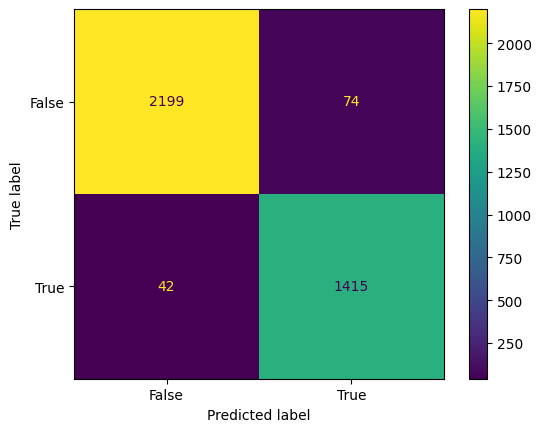

In [17]:
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True]) 
cm_display.plot()
plt.show() 

In [ ]:
"""
Epoch 1/4, Loss: 0.0741, Val Loss: 0.1948, Val Acc: 0.9172, Precision: 0.9037, Recall: 0.8819, F1 Score: 0.8927
Epoch 2/4, Loss: 0.0198, Val Loss: 0.1649, Val Acc: 0.9324, Precision: 0.8920, Recall: 0.9410, F1 Score: 0.9158
Epoch 3/4, Loss: 0.5584, Val Loss: 0.1488, Val Acc: 0.9375, Precision: 0.9048, Recall: 0.9389, F1 Score: 0.9215
Epoch 4/4, Loss: 0.1187, Val Loss: 0.1523, Val Acc: 0.9389, Precision: 0.9121, Recall: 0.9334, F1 Score: 0.9227
"""

In [41]:
# Train the Random Forest classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=18)
random_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=17, random_state=42)

In [42]:
# Predict on the test set
predictions = random_forest.predict(X_test)
predictions_t = random_forest.predict(X_train)
print(predictions.shape)

# Compute F1 score
f1 = f1_score(y_test, predictions)
f1_t = f1_score(y_train, predictions_t)
cm = confusion_matrix(y_test, predictions)
print(cm)
cm = confusion_matrix(y_train, predictions_t)
print(cm)
print("F1 Score:", f1, f1_t)

(3730,)
[[2191   82]
 [ 102 1355]]
[[8874  175]
 [  38 5833]]
F1 Score: 0.9364201796821009 0.9820691977439179


- max depth 8:    F1 Score: 0.9009653199856991 0.9287016934433349
- md 9:           F1 Score: 0.9124911785462243 0.9407515693524809
- md 10:          F1 Score: 0.9147506190307747 0.9501285347043702
- md 11:          F1 Score: 0.9231843575418994 0.9609375
- md 12:          F1 Score: 0.9260945709281961 0.9663951120162932
- md 13:          F1 Score: 0.930589466341123 0.9703238935051721
- md 14:          F1 Score: 0.9333333333333333 0.9747145877378436
- md 15:          F1 Score: 0.932822833275322 0.9772036474164133
- md 16:          F1 Score: 0.9377162629757786 0.9806234203875316
- md 17:          F1 Score: 0.9364201796821009 0.9820691977439179

In [50]:
# use gaussian kernel, so gamma 
svm_classifier = SVC(kernel='rbf', gamma='scale', C=1.0, random_state=42) # 'scale' is one option for auto-scaling gamma
# can also specify a specific value for gamma, ie.  gamma=0.1

svm_classifier.fit(X_train, y_train)

# Predict on the test set
s_predictions = svm_classifier.predict(X_test)

accuracy = accuracy_score(y_test, s_predictions)
f1 = f1_score(y_test, s_predictions)
cm = confusion_matrix(y_test,s_predictions)
print(cm)
print(f'Accuracy: {accuracy} f1: {f1}')

[[2188   85]
 [  29 1428]]
Accuracy: 0.9694369973190349 f1: 0.9616161616161616


In [51]:
logistic_model = LogisticRegression(random_state=42)

# Fit the model on the standardized training data
logistic_model.fit(X_train, y_train)

# Make predictions on the standardized test set
y_pred = logistic_model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
cm = confusion_matrix(y_test,predictions)
print(cm)
print(f'Accuracy: {accuracy} f1: {f1}')

[[2188   85]
 [  29 1428]]
Accuracy: 0.9694369973190349 f1: 0.9616161616161616


In [ ]:
for i in range(len(predictions)):
    if predictions[i]!=s_predictions[i]:
        print(i)

In [ ]:
# Specify the file path where you want to save the model
model_filename = 'trained_weights/svm_classifier_model_tfidf.pkl'

# Save the trained SVM model to a file
joblib.dump(svm_classifier, model_filename)

print("Model saved successfully at:", model_filename)